# Paper Grading Assistant

## Modeling

Data comes from this link:
- https://www.kaggle.com/c/asap-aes/data

Heavy inspiration drawn from:
- https://towardsdatascience.com/topic-modeling-articles-with-nmf-8c6b2a227a45
(Use incognito window when opening that link)

In [37]:
# !pip install gensim
import os, sys
import csv
from gensim import corpora, models
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re


In [38]:
# Helper Functions
# Run the utilty functions from a seperate notebook
%run topic_model_utils.ipynb

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\maxw2\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\maxw2\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [39]:
data = pd.read_csv("D:\\Kaggle\\asap-aes\\training_set_rel3.tsv", sep='\t')
data = replicate_csv(data)
# data.head()

<ipython-input-38-e22088476dcb>:244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['class'][x] = 2
<ipython-input-38-e22088476dcb>:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['class'][x] = 3
<ipython-input-38-e22088476dcb>:238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['class'][x] = 4
<ipython-input-38-e22088476dcb>:235: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

In [40]:
# drop some unused features
cols_to_drop = [col for col in data.columns if 'rater' in col]
data = data.drop(columns=cols_to_drop)

# data

In [41]:
df = data[data['word_count'] > 25]
df.shape

(12793, 10)

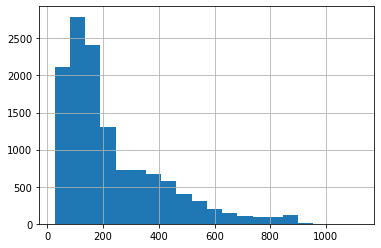

In [42]:
df['word_count'].hist(bins=20);

In [43]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

no_features = 1000
print(df['tokenized_essay'])

# NMF is able to use tf-idf
tfidf_vectorizer = TfidfVectorizer(max_df=0.85, 
                                   min_df=3, 
                                   max_features=no_features, 
                                   stop_words='english', 
                                   preprocessor=' '.join)
tfidf = tfidf_vectorizer.fit_transform(df['tokenized_essay']) # tfidf embeddings
# print("tfidf: \n", tfidf)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

# LDA can only use raw term counts for LDA because it is a probabilistic graphical model
tf_vectorizer = CountVectorizer(max_df=0.85, 
                                min_df=3, 
                                max_features=no_features, 
                                stop_words='english', 
                                preprocessor=' '.join)
tf = tf_vectorizer.fit_transform(df['tokenized_essay']) # tf embeddings
# print("tf: \n", tf)
tf_feature_names = tf_vectorizer.get_feature_names()

0        [dear, local, newspaper, think, effect, comput...
1        [dear, believe, using, computer, benefit, way,...
2        [dear, people, use, computer, agrees, benefit,...
3        [dear, local, newspaper, expert, computer, ben...
4        [dear, location, know, having, computer, posit...
                               ...                        
12971    [story, mother, daughter, enemy, friend, story...
12972    [understood, meaning, laughter, shortest, dist...
12973    [laugh, habit, cause, cause, laughing, thing, ...
12974    [trippin, fence, num, year, young, short, num,...
12975    [people, believe, laughter, improve, life, lau...
Name: tokenized_essay, Length: 12793, dtype: object


In [44]:
from sklearn.decomposition import NMF, LatentDirichletAllocation

n_components = 10

# Run NMF
nmf = NMF(n_components=n_components, random_state=1, 
          alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)

# Run LDA
lda = LatentDirichletAllocation(n_components=n_components, max_iter=5, 
                                learning_method='online', learning_offset=50.,
                                random_state=0).fit(tf)



In [45]:
# Use the top words for each cluster by tfidf weight
# to create 'topics'

# Getting a df with each topic by document
nmf_docweights = nmf.transform(tfidf_vectorizer.transform(df['tokenized_essay']))

n_top_words = 10

nmf_topic_df = topic_table(
    nmf,
    tfidf_feature_names,
    n_top_words
).T

# Cleaning up the top words to create topic summaries
nmf_topic_df['topics'] = nmf_topic_df.apply(lambda x: [' '.join(x)], axis=1) # Joining each word into a list
nmf_topic_df['topics'] = nmf_topic_df['topics'].str[0]  # Removing the list brackets
nmf_topic_df['topics'] = nmf_topic_df['topics'].apply(lambda x: whitespace_tokenizer(x)) # tokenize
nmf_topic_df['topics'] = nmf_topic_df['topics'].apply(lambda x: unique_words(x))  # Removing duplicate words
nmf_topic_df['topics'] = nmf_topic_df['topics'].apply(lambda x: [' '.join(x)])  # Joining each word into a list
nmf_topic_df['topics'] = nmf_topic_df['topics'].str[0]  # Removing the list brackets

# nmf_topic_df.head()

In [46]:
# Do the same with bag of words weight
# to create 'topics'

lda_docweights = lda.transform(tf_vectorizer.transform(df['tokenized_essay']))

n_top_words = 10

lda_topic_df = topic_table(
    lda,
    tf_feature_names,
    n_top_words
).T

# Cleaning up the top words to create topic summaries
lda_topic_df['topics'] = lda_topic_df.apply(lambda x: [' '.join(x)], axis=1) # Joining each word into a list
lda_topic_df['topics'] = lda_topic_df['topics'].str[0]  # Removing the list brackets
lda_topic_df['topics'] = lda_topic_df['topics'].apply(lambda x: whitespace_tokenizer(x)) # tokenize
lda_topic_df['topics'] = lda_topic_df['topics'].apply(lambda x: unique_words(x))  # Removing duplicate words
lda_topic_df['topics'] = lda_topic_df['topics'].apply(lambda x: [' '.join(x)])  # Joining each word into a list
lda_topic_df['topics'] = lda_topic_df['topics'].str[0]  # Removing the list brackets

# lda_topic_df.head()

In [47]:

# Create a df with only the created topics and topic num
lda_topic_df = lda_topic_df['topics'].reset_index()
lda_topic_df.columns = ['lda_topic_num', 'topics']

lda_topic_df.head()

,lda_topic_num,topics
0,0,computer people time family weight spend frien...
1,1,place people location learn talk coordination ...
2,2,person time got patient num day went mom going...
3,3,computer people help thing use friend way thin...
4,4,book library people offensive movie read child...


In [48]:

# Create a df with only the created topics and topic num
nmf_topic_df = nmf_topic_df['topics'].reset_index()
nmf_topic_df.columns = ['nmf_topic_num', 'topics']

nmf_topic_df.head()

,nmf_topic_num,topics
0,0,computer people friend help time use family on...
1,1,building dirigible obstacle empire state mast ...
2,2,mood parent memoir family narciso love gratefu...
3,3,book library offensive people movie read shelf...
4,4,cyclist setting water feature affect road hill...


In [49]:
# Creating a temp df with the id and topic num to join on
id_ = df['essay_id'].tolist()
df_temp1 = pd.DataFrame({
    'essay_id': id_,
    'nmf_topic_num': nmf_docweights.argmax(axis=1)
})

merged_topic1 = df_temp1.merge(
    nmf_topic_df,
    on='nmf_topic_num',
    how='left'
)

df_temp2 = pd.DataFrame({
    'essay_id': id_,
    'lda_topic_num': lda_docweights.argmax(axis=1)
})

merged_topic2 = df_temp2.merge(
    lda_topic_df,
    on='lda_topic_num',
    how='left'
)

# Merging to get the topic num with id
merged_topic = merged_topic1.merge(
    merged_topic2,
    on='essay_id',
    how='left'
)

# Merging with the original df
df_topics = pd.merge(
    df,
    merged_topic,
    on='essay_id',
    how='left'
)

df_topics = df_topics.rename(columns={'topics_x' : 'nmf_topic', 'topics_y' : 'lda_topic' })

df_topics.head(15)

,essay_id,essay_set,essay,domain1_score,domain2_score,tokenized_essay,word_count,max_score,pct_score,class,nmf_topic_num,nmf_topic,lda_topic_num,lda_topic
0,1,1,"Dear local newspaper, I think effects computer...",8,0.0,"[dear, local, newspaper, think, effect, comput...",338,12,0.666667,2,0,computer people friend help time use family on...,3,computer people help thing use friend way thin...
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",9,0.0,"[dear, believe, using, computer, benefit, way,...",419,12,0.750000,3,0,computer people friend help time use family on...,3,computer people help thing use friend way thin...
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",7,0.0,"[dear, people, use, computer, agrees, benefit,...",279,12,0.583333,1,0,computer people friend help time use family on...,3,computer people help thing use friend way thin...
3,4,1,"Dear Local Newspaper, @CAPS1 I have found that...",10,0.0,"[dear, local, newspaper, expert, computer, ben...",524,12,0.833333,4,0,computer people friend help time use family on...,3,computer people help thing use friend way thin...
4,5,1,"Dear @LOCATION1, I know having computers has a...",8,0.0,"[dear, location, know, having, computer, posit...",465,12,0.666667,2,0,computer people friend help time use family on...,3,computer people help thing use friend way thin...
5,6,1,"Dear @LOCATION1, I think that computers have a...",8,0.0,"[dear, location, think, computer, negative, af...",246,12,0.666667,2,0,computer people friend help time use family on...,3,computer people help thing use friend way thin...
6,7,1,Did you know that more and more people these d...,10,0.0,"[did, know, people, day, depending, computer, ...",499,12,0.833333,4,0,computer people friend help time use family on...,3,computer people help thing use friend way thin...
7,8,1,@PERCENT1 of people agree that computers make ...,10,0.0,"[percent, people, agree, computer, make, life,...",482,12,0.833333,4,0,computer people friend help time use family on...,3,computer people help thing use friend way thin...
8,9,1,"Dear reader, @ORGANIZATION1 has had a dramatic...",9,0.0,"[dear, reader, organization, dramatic, effect,...",443,12,0.750000,3,0,computer people friend help time use family on...,3,computer people help thing use friend way thin...
9,10,1,In the @LOCATION1 we have the technology of a ...,9,0.0,"[location, technology, computer, computer, goo...",502,12,0.750000,3,0,computer people friend help time use family on...,3,computer people help thing use friend way thin...


In [50]:

A = tfidf_vectorizer.transform(df_topics['essay'])
W = nmf.components_
H = nmf.transform(A)

print('A = {} x {}'.format(A.shape[0], A.shape[1]))
print('W = {} x {}'.format(W.shape[0], W.shape[1]))
print('H = {} x {}'.format(H.shape[0], H.shape[1]))

# Get the residuals for each document
r = np.zeros(A.shape[0])

for row in range(A.shape[0]):
    r[row] = np.linalg.norm(A[row, :] - H[row, :].dot(W), 'fro')

sum_sqrt_res = round(sum(np.sqrt(r)), 3)
print('Sum of the squared residuals is {}'.format(sum_sqrt_res))

A = 12793 x 1000
W = 10 x 1000
H = 12793 x 10
Sum of the squared residuals is 0.0


In [51]:
def add_carriage_returns(text):
    arr = text.split(' ')
    for i in range(1,len(arr)+1):
        if i % 15 == 0:
            arr.insert(i, '\n')
    text = " ".join(arr)
    return text

# df_topics['essay'] = df_topics['essay'].apply(add_carriage_returns)

def print_lines(idx):
    print('=====')
    print('entry: ', idx)
    print(df_topics['essay'][idx])
    print(' ')
    print('Topics:')
    print("nmf topics:", df_topics['nmf_topic'][idx])
    print("lda topics:", df_topics['lda_topic'][idx])
    print('=====')

for i in range(0,20):
    print_lines(i)

=====
entry:  0
Dear local newspaper, I think effects computers have on people are great learning skills/affects because they give us time to chat with friends/new people, helps us learn about the globe(astronomy) and keeps us out of troble! Thing about! Dont you think so? How would you feel if your teenager is always on the phone with friends! Do you ever time to chat with your friends or buisness partner about things. Well now - there's a new way to chat the computer, theirs plenty of sites on the internet to do so: @ORGANIZATION1, @ORGANIZATION2, @CAPS1, facebook, myspace ect. Just think now while your setting up meeting with your boss on the computer, your teenager is having fun on the phone not rushing to get off cause you want to use it. How did you learn about other countrys/states outside of yours? Well I have by computer/internet, it's a new way to learn about what going on in our time! You might think your child spends a lot of time on the computer, but ask them so question a

In [52]:
def build_wordcloud(feature_count, vectorizer):
    from wordcloud import WordCloud
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10))

    n_entries = 20

    vals_to_display = feature_count.sort_values(by='feat_count', ascending=False).head(n_entries)

    ax2.bar(x=vals_to_display.feat_name.values, height=vals_to_display.feat_count.values)

    # define a wordcloud
    wc = WordCloud(background_color="white")
    wc.generate(" ".join(vectorizer.get_feature_names()))

    ax1.imshow(wc, interpolation="bilinear")
    ax1.axis("off")

    plt.setp(ax2.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")
    plt.show()

In [53]:
tf_feature_count = pd.DataFrame({
    "feat_name": tf_feature_names, 
    "feat_count": tf.toarray().sum(axis=0).tolist()
})
tf_feature_count.sort_values(by='feat_count', ascending=False).head(20)


,feat_name,feat_count
650,people,21165
163,computer,20067
82,book,13964
893,time,11333
885,thing,10572
653,person,9520
886,think,8179
98,building,8086
610,num,7248
510,library,7214


In [54]:
tfidf_feature_count = pd.DataFrame({
    "feat_name": tfidf_feature_names, 
    "feat_count": tfidf.toarray().sum(axis=0).tolist()
})
tfidf_feature_count.sort_values(by='feat_count', ascending=False).head(20)

,feat_name,feat_count
163,computer,862.697718
650,people,666.993096
98,building,583.266682
82,book,564.855941
52,author,482.347975
229,dirigible,475.869400
893,time,451.187912
833,story,423.125959
582,mood,413.267547
200,cyclist,411.201147


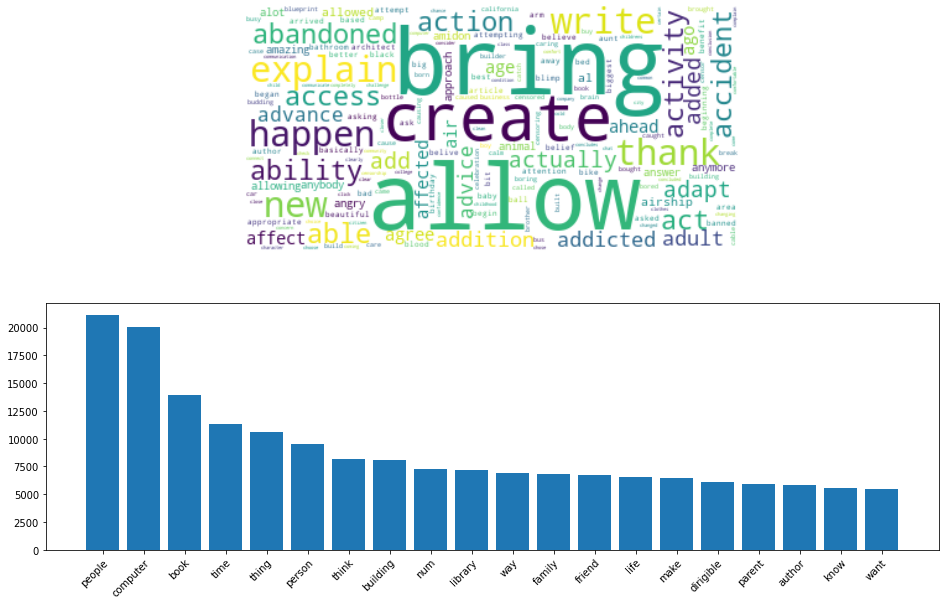

In [55]:
build_wordcloud(tf_feature_count, tf_vectorizer)

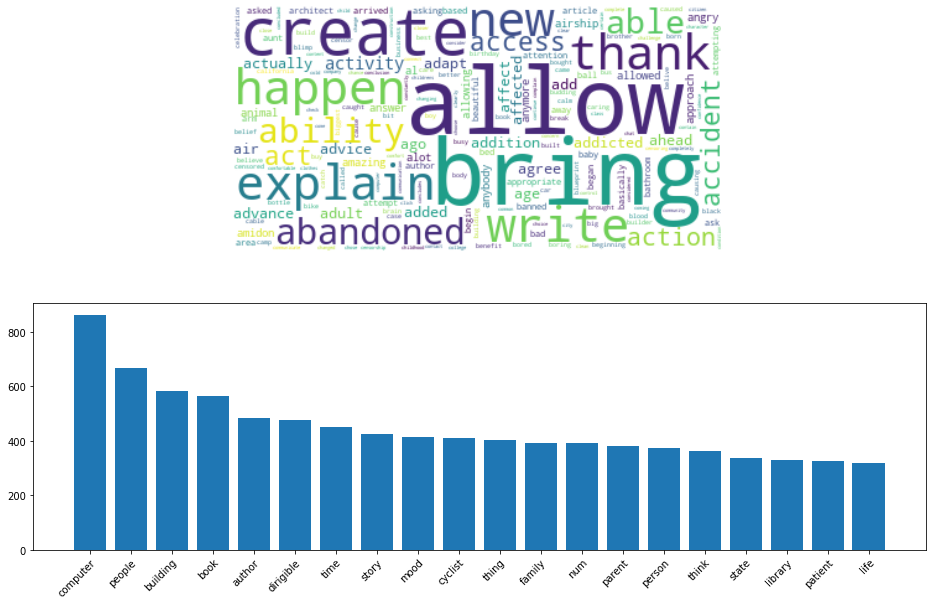

In [56]:
build_wordcloud(tfidf_feature_count, tfidf_vectorizer)

In [57]:
model = get_model()
for row in df_topics['nmf_topic'].unique():
    phrase = row.split()
    arr = []
    for word in phrase:
        arr.append(word)
    # print(arr)
    label = reduce_words(arr, model, reductions=6)

In [58]:
df_topics['top_label'] = 'n/a'
for row in df_topics['lda_topic'].unique():
    phrase = row.split()
    arr = []
    for word in phrase:
        arr.append(word)
    # print(arr)
    label = reduce_words(arr, model)
    df_topics.loc[df_topics['lda_topic'] == ' '.join(phrase), 'top_label'] = label
df_topics

,essay_id,essay_set,essay,domain1_score,domain2_score,tokenized_essay,word_count,max_score,pct_score,class,nmf_topic_num,nmf_topic,lda_topic_num,lda_topic,top_label
0,1,1,"Dear local newspaper, I think effects computer...",8,0.0,"[dear, local, newspaper, think, effect, comput...",338,12,0.666667,2,0,computer people friend help time use family on...,3,computer people help thing use friend way thin...,really
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",9,0.0,"[dear, believe, using, computer, benefit, way,...",419,12,0.750000,3,0,computer people friend help time use family on...,3,computer people help thing use friend way thin...,really
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",7,0.0,"[dear, people, use, computer, agrees, benefit,...",279,12,0.583333,1,0,computer people friend help time use family on...,3,computer people help thing use friend way thin...,really
3,4,1,"Dear Local Newspaper, @CAPS1 I have found that...",10,0.0,"[dear, local, newspaper, expert, computer, ben...",524,12,0.833333,4,0,computer people friend help time use family on...,3,computer people help thing use friend way thin...,really
4,5,1,"Dear @LOCATION1, I know having computers has a...",8,0.0,"[dear, location, know, having, computer, posit...",465,12,0.666667,2,0,computer people friend help time use family on...,3,computer people help thing use friend way thin...,really
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12788,21626,8,In most stories mothers and daughters are eit...,35,0.0,"[story, mother, daughter, enemy, friend, story...",848,60,0.583333,1,7,person laughter laugh laughing friend time day...,9,laughter laugh laughing make thing friend peop...,really
12789,21628,8,I never understood the meaning laughter is th...,32,0.0,"[understood, meaning, laughter, shortest, dist...",548,60,0.533333,1,7,person laughter laugh laughing friend time day...,2,person time got patient num day went mom going...,just
12790,21629,8,"When you laugh, is @CAPS5 out of habit, or is ...",40,0.0,"[laugh, habit, cause, cause, laughing, thing, ...",818,60,0.666667,2,7,person laughter laugh laughing friend time day...,9,laughter laugh laughing make thing friend peop...,really
12791,21630,8,Trippin' on fen...,40,0.0,"[trippin, fence, num, year, young, short, num,...",594,60,0.666667,2,7,person laughter laugh laughing friend time day...,2,person time got patient num day went mom going...,just


Some thoughts here:

The actual label doesn't really matter, so long as all the labels are different. In this case, <br>
it seems like LDA is the top performing model.

Now, we have a word to associate with each body of writing. We can use that word to <br>
find similarities with topics of a paragraph to track coherence between paragraphs. <br>
As long as a paper maintains some kind of similarity between paragraphs (say, > 0.5) <br>
then perhaps that's an indicator that the writer has good organization in his / her paper. <br>

If not, then that could be suggested feedback left by the algorithm. Then teachers can <br>
agree or disagree with the feedback with a simple click of a button, or they can edit it <br>
instead of having to come up with it all on their own. <br>

In [59]:
for i in range(1,8):
    print(df_topics.loc[df_topics['essay_set'] == i, 'lda_topic_num'].unique())

[3 0 1 2 9]
[4 3 9 2]
[7 5 9 2 4 3 0 1]
[7 8 2 4 0 6 3 9]
[6 9 7 2 4]
[5 2 9 3]
[2 9 4 3 7 0 6]


In [60]:
# it looks like there's some variation in the topics 
# among essay sets, which is good. the next step is
# to test these models and see how they do. to do 
# that, I'm going to randomly "generate" some essays
# and run them through these models to see how they would 
# be graded.

# generate random integer values
from random import seed, randint
# seed random number generator
seed(10)
seed(randint(1,25))

# short papers
stack_of_short_papers = []
for _ in range(5):
    short_paper = []
    for i in range(2):
        short_para = ''
        value = randint(1, 8)
        end_range = len(df_topics.loc[df_topics['essay_set'] == value, 'essay'])
        value2 = randint(0, end_range)
        short_para = df_topics.loc[df_topics['essay_set'] == value, 'essay'].iloc[value2]
        short_paper.append(short_para)
    stack_of_short_papers.append(short_paper)

for i in range(len(stack_of_short_papers)):
    stack_of_short_papers[i] = '\n'.join(stack_of_short_papers[i])
# stack_of_short_papers

In [61]:
# med papers
seed(randint(1,25))

stack_of_med_papers = []
# total num of papers
for _ in range(5):
    med_paper = []
    # length of paper
    for i in range(5):
        med_para = ''
        value = randint(1, 8)
        end_range = len(df_topics.loc[df_topics['essay_set'] == value, 'essay'])
        value2 = randint(0, end_range)
        med_para = df_topics.loc[df_topics['essay_set'] == value, 'essay'].iloc[value2]
        med_paper.append(med_para)
    stack_of_med_papers.append(med_paper)

for i in range(len(stack_of_med_papers)):
    stack_of_med_papers[i] = '\n'.join(stack_of_med_papers[i])

In [62]:
# long papers
seed(randint(1,25))

stack_of_long_papers = []
# total num of papers
for _ in range(5):
    long_paper = []
    # length of paper
    for i in range(10):
        long_para = ''
        value = randint(1, 8)
        end_range = len(df_topics.loc[df_topics['essay_set'] == value, 'essay'])
        value2 = randint(0, end_range)
        long_para = df_topics.loc[df_topics['essay_set'] == value, 'essay'].iloc[value2]
        long_paper.append(long_para)
    stack_of_long_papers.append(long_paper)

for i in range(len(stack_of_long_papers)):
    stack_of_long_papers[i] = '\n'.join(stack_of_long_papers[i])

In [76]:
# for debugging
%run topic_model_utils.ipynb

def stack2df(arr):
    df = pd.DataFrame(arr, columns=['essay'])
    return df

def essay2df(essay):
    paragraphs = essay.split('\n')
    df = pd.DataFrame(paragraphs, columns=['paragraphs'])
    return df

s = stack2df(stack_of_long_papers)
p = essay2df(s['essay'].iloc[4])
p['para_id'] = range(1,len(p)+1)
p['word_count'] = p.paragraphs.apply(word_count)
p['token_p'] = p.paragraphs.apply(process_text)
p['token_count'] = p.token_p.apply(len)
p_topics = generate_para_topics(p)
p_topics.head(10)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\maxw2\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\maxw2\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,paragraphs,para_id,word_count,token_p,token_count,lda_topic_num,topics,top_label
0,The features of the setting in �Rough Road Ahe...,1,165,"[feature, setting, rough, road, ahead, exceed,...",73,9,building cyclist heat riding sure probably pro...,tired
1,The problems that the Building had to face the...,2,40,"[problem, building, face, unsolve, problem, mo...",18,9,building cyclist heat riding sure probably pro...,tired
2,The setting of a situation can affect a person...,3,207,"[setting, situation, affect, person, mentally,...",91,4,cyclist setting limit example feel sad home nu...,feel
3,"It's true @CAPS8 they say, time flies when you...",4,716,"[true, time, fly, having, fun, particularly, w...",267,7,going person people laugh year laughter life t...,time
4,In Narciso Rodriguez from Home the @CAPS1 @CAP...,5,152,"[narciso, rodriguez, home, life, mood, created...",45,4,cyclist setting limit example feel sad home nu...,feel
5,"Have you ever seen the phrase @CAPS1,@CAPS2,La...",6,552,"[seen, phrase, laughter, asked, mean, believe,...",206,7,going person people laugh year laughter life t...,time
6,During the @DATE1 I decided to join @ORGANIZAT...,7,413,"[date, decided, join, organization, raised, ma...",158,5,organization pig person time raising date expe...,date
7,The time I had to be patient was when I had to...,8,137,"[time, patient, wait, line, ride, shoot, point...",56,8,ride patient line num time got wait worth peop...,people
8,It was late @DATE1 when my @CAPS1 is and I wa...,9,322,"[late, date, going, point, forever, drive, sit...",100,8,ride patient line num time got wait worth peop...,people
9,Why do we have books out there that are viewed...,10,530,"[book, viewed, offensive, inapropriate, puttin...",157,3,music book child num life cartoon make good go...,num


In [77]:
# now that we have labels for paragraphs,
# we want to see which label occurs the most.
# if it hits a certain frequency threshold, 
# say 60%, then that means the paper is probably
# well-organized.
high_num_same_top = p_topics['top_label'].value_counts()[0]
p_topics_len = len(p_topics)
high_num_same_top / p_topics_len

0.2

In [65]:
# set top label with probabilities
docsVStopics = pd.DataFrame(lda_docweights, columns=["Topic "+str(i) for i in range(n_top_words)])
print("Created a (%dx%d) document-topic matrix." % (docsVStopics.shape[0], docsVStopics.shape[1]))
docsVStopics.head()

Created a (12793x10) document-topic matrix.


,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9
0,0.123706,0.000813,0.045113,0.735855,0.080879,0.000813,0.000813,0.010380,0.000813,0.000813
1,0.000685,0.000685,0.000685,0.993834,0.000685,0.000685,0.000685,0.000685,0.000685,0.000685
2,0.353396,0.000926,0.000926,0.624523,0.000926,0.000926,0.000926,0.015598,0.000926,0.000926
3,0.000588,0.000588,0.000588,0.994705,0.000588,0.000588,0.000588,0.000588,0.000589,0.000588
4,0.000725,0.058760,0.000725,0.912690,0.023477,0.000725,0.000725,0.000725,0.000725,0.000725


In [66]:
most_likely_topics = docsVStopics.idxmax(axis=1)
